# Fashion MNIST Image Classification with CNNs  
**Project By:** Ashkan Alinaghian, Arian PourEsmaeili, MohammadMahdi Khorsandpour  
**Date:** April 2025  

## Project Description  
This project implements and compares **three convolutional neural networks (CNNs)** for classifying clothing items in the Fashion MNIST dataset. We explore transfer learning, model complexity, and robustness to IIIF-annotated data distortions.  

**Key Objectives:**  
- Compare **transfer learning** (MNIST-pretrained) vs. **scratch-trained** vs. **deep CNNs** with advanced regularization.  
- Evaluate model generalization on IIIF-annotated samples and cross-dataset (MNIST digits).  
- Analyze misclassification patterns using confusion matrices and qualitative error analysis.  

**Methods & Tools:**  
- **Models:**  
  - Transfer Model (MNIST-pretrained feature extractor)  
  - Scratch Model (custom 4-layer CNN)  
  - Deep Model (BatchNorm, Dropout, Global Average Pooling)  
- **Techniques:** Data augmentation, class weighting, cross-validation, Adam/SGD optimization.  
- **Tools:** TensorFlow/Keras, IIIF Workbench for annotation, scikit-learn for evaluation.  

**Key Results:**  
- **Deep Model Achieved 91.3% Test Accuracy** (vs. 90.6% Scratch, 86.2% Transfer).  
- **IIIF Preprocessing Caused 20-30% Accuracy Drops** due to resizing artifacts.  
- **Shirts/Coats/Pullovers** were most error-prone (e.g., 25% misclassification rate for shirts).  
- **Cross-Dataset Generalization Failed** (10-12% accuracy on MNIST digits).  

**Conclusion:** Custom CNNs outperform ResNet18/LeNet5 on Fashion MNIST but remain sensitive to IIIF distortions.  

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load Fashion MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Class names
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add channel dimension (required for CNNs)
x_train = np.expand_dims(x_train, axis=-1)  # New shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)

# Split training data into training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.15,
    random_state=42,
    stratify=y_train
)

# Print shapes
print("Training data shape:", x_train.shape)   # (51000, 28, 28, 1)
print("Validation data shape:", x_val.shape)   # (9000, 28, 28, 1)
print("Test data shape:", x_test.shape)        # (10000, 28, 28, 1)

Training data shape: (51000, 28, 28, 1)
Validation data shape: (9000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


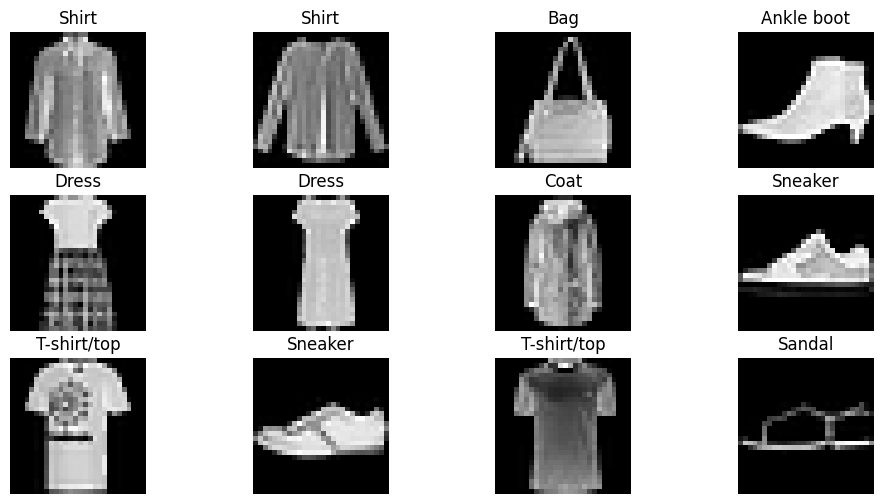

In [3]:
plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()

In [4]:
from tensorflow.keras import layers, models

# Step 1: Train a CNN on MNIST (digits)

# Load MNIST
(x_mnist_train, y_mnist_train), _ = tf.keras.datasets.mnist.load_data()
x_mnist_train = x_mnist_train.astype('float32') / 255.0
x_mnist_train = np.expand_dims(x_mnist_train, axis=-1)

# Define and train MNIST model
model_mnist = models.Sequential([
    layers.Input(shape=(28, 28, 1)),  # Explicitly define input
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes for digits
])
model_mnist.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_mnist.fit(x_mnist_train, y_mnist_train, epochs=5, batch_size=64)

model_mnist.save('mnist_pretrained.h5')

# Step 2: Transfer Learning to Fashion MNIST

# Load the pretrained model and remove the last 2 layers (classifier)
pretrained_base = models.load_model('mnist_pretrained.h5')
pretrained_base.pop()  # Remove last layer (Dense 10)
pretrained_base.pop()  # Remove second-to-last layer (Dense 64)
pretrained_base.trainable = False  # Freeze layers

# Add new classifier for Fashion MNIST
model_transfer = models.Sequential([
    pretrained_base,
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes for Fashion MNIST
])
model_transfer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_transfer.summary()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8738 - loss: 0.4113
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9823 - loss: 0.0557
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9875 - loss: 0.0402
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9913 - loss: 0.0299
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9929 - loss: 0.0221


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 1600)                │          18,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 206,218 (805.54 KB)

 Non-trainable params: 18,816 (73.50 KB)

In [5]:
model_scratch = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model_scratch.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_scratch.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:

# New SGD Model for Optimizer Comparison

model_scratch_sgd = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile with SGD instead of Adam
model_scratch_sgd.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_scratch_sgd.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model_deep = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
model_deep.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_deep.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,346 (368.54 KB)

 Trainable params: 94,154 (367.79 KB)

 Non-trainable params: 192 (768.00 B)

In [8]:
# Train Transfer Learning Model
history_transfer = model_transfer.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_val, y_val),
    batch_size=64
)

# Train Scratch Model
history_scratch = model_scratch.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_val, y_val),
    batch_size=64
)

# Train Deep Model
history_deep = model_deep.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_val, y_val),
    batch_size=64
)

Epoch 1/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7999 - loss: 0.5784 - val_accuracy: 0.8666 - val_loss: 0.3667
Epoch 2/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8842 - loss: 0.3257 - val_accuracy: 0.8830 - val_loss: 0.3219
Epoch 3/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8954 - loss: 0.2858 - val_accuracy: 0.8906 - val_loss: 0.3035
Epoch 4/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9048 - loss: 0.2580 - val_accuracy: 0.8963 - val_loss: 0.2887
Epoch 5/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9134 - loss: 0.2338 - val_accuracy: 0.8889 - val_loss: 0.3087
Epoch 6/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9214 - loss: 0.2173 - val_accuracy: 0.8937 - val_loss: 0.3073
Epoch 7/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9265 - loss: 0.1984 - val_accuracy: 0.9008 - val_loss: 0.2868
Epoch 8/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9302 - loss: 0.1870 - val_accuracy: 0.

In [9]:
from sklearn.metrics import classification_report

def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    print(classification_report(y_test, y_pred_labels, target_names=class_names))

# Evaluate Transfer Model
print("Transfer Learning Model:")
evaluate_model(model_transfer, x_test, y_test)

# Evaluate Scratch Model
print("Scratch Model:")
evaluate_model(model_scratch, x_test, y_test)

# Evaluate Deep Model
print("Deep Model:")
evaluate_model(model_deep, x_test, y_test)

Transfer Learning Model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.79      0.83      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.90      0.63      0.74      1000
       Dress       0.92      0.89      0.91      1000
        Coat       0.75      0.86      0.81      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.60      0.79      0.68      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.97      0.96      0.97      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000

Scratch Model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.90      0.86      1000
     Trous

In [10]:
# Train the transfer learning model
history_transfer = model_transfer.fit(
    x_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

model_transfer.save('fashion_transfer_model.h5')

Epoch 1/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9418 - loss: 0.1555 - val_accuracy: 0.9014 - val_loss: 0.3130
Epoch 2/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9504 - loss: 0.1383 - val_accuracy: 0.9032 - val_loss: 0.3043
Epoch 3/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9523 - loss: 0.1314 - val_accuracy: 0.9000 - val_loss: 0.3216
Epoch 4/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9544 - loss: 0.1253 - val_accuracy: 0.9049 - val_loss: 0.3198
Epoch 5/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9558 - loss: 0.1180 - val_accuracy: 0.9007 - val_loss: 0.3506


In [11]:
# Train the scratch model
history_scratch = model_scratch.fit(
    x_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

# Save the model
model_scratch.save('fashion_scratch_model.h5')
# Train Scratch Model with SGD
history_scratch_sgd = model_scratch_sgd.fit(
    x_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

model_scratch_sgd.save('fashion_scratch_sgd_model.h5')



Epoch 1/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9561 - loss: 0.1179 - val_accuracy: 0.9159 - val_loss: 0.2456
Epoch 2/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9596 - loss: 0.1074 - val_accuracy: 0.9212 - val_loss: 0.2499
Epoch 3/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9643 - loss: 0.0984 - val_accuracy: 0.9137 - val_loss: 0.2627
Epoch 4/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9692 - loss: 0.0845 - val_accuracy: 0.9087 - val_loss: 0.3078


Epoch 1/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6504 - loss: 0.9731 - val_accuracy: 0.8382 - val_loss: 0.4391
Epoch 2/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8446 - loss: 0.4247 - val_accuracy: 0.8616 - val_loss: 0.3747
Epoch 3/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8681 - loss: 0.3607 - val_accuracy: 0.8797 - val_loss: 0.3253
Epoch 4/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8861 - loss: 0.3142 - val_accuracy: 0.8938 - val_loss: 0.2957
Epoch 5/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8904 - loss: 0.2935 - val_accuracy: 0.8997 - val_loss: 0.2820
Epoch 6/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9005 - loss: 0.2693 - val_accuracy: 0.8988 - val_loss: 0.2817
Epoch 7/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9060 - loss: 0.2541 - val_accuracy: 0.9031 - val_loss: 0.2702
Epoch 8/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9110 - loss: 0.2351 - val_accuracy: 0.

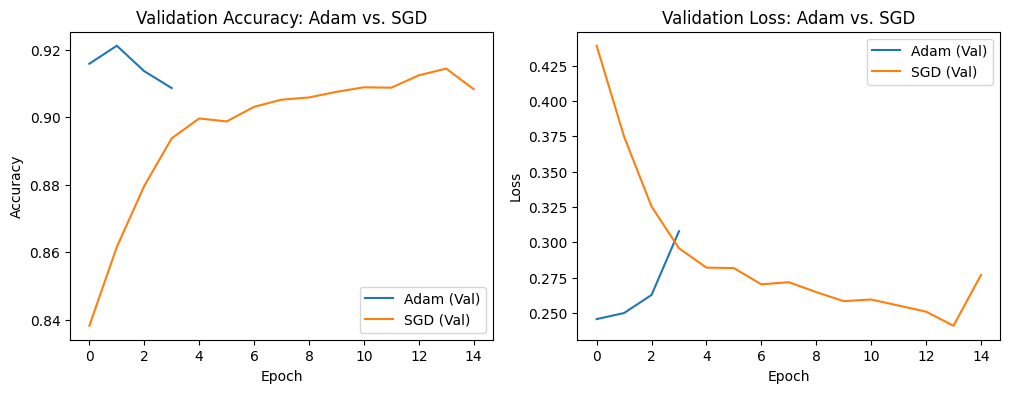

In [12]:
# Compare Adam vs. SGD
def compare_optimizers(history_adam, history_sgd):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_adam.history['val_accuracy'], label='Adam (Val)')
    plt.plot(history_sgd.history['val_accuracy'], label='SGD (Val)')
    plt.title('Validation Accuracy: Adam vs. SGD')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_adam.history['val_loss'], label='Adam (Val)')
    plt.plot(history_sgd.history['val_loss'], label='SGD (Val)')
    plt.title('Validation Loss: Adam vs. SGD')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

compare_optimizers(history_scratch, history_scratch_sgd)

In [13]:
# Train the deep model
history_deep = model_deep.fit(
    x_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

model_deep.save('fashion_deep_model.h5')

Epoch 1/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9246 - loss: 0.2063 - val_accuracy: 0.9008 - val_loss: 0.2680
Epoch 2/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9288 - loss: 0.1971 - val_accuracy: 0.9108 - val_loss: 0.2492
Epoch 3/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9291 - loss: 0.1898 - val_accuracy: 0.9138 - val_loss: 0.2532
Epoch 4/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9308 - loss: 0.1854 - val_accuracy: 0.9111 - val_loss: 0.2553
Epoch 5/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9334 - loss: 0.1789 - val_accuracy: 0.9209 - val_loss: 0.2313
Epoch 6/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9390 - loss: 0.1688 - val_accuracy: 0.9199 - val_loss: 0.2349
Epoch 7/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9392 - loss: 0.1641 - val_accuracy: 0.8981 - val_loss: 0.2905
Epoch 8/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9422 - loss: 0.1527 - val_accuracy: 0.

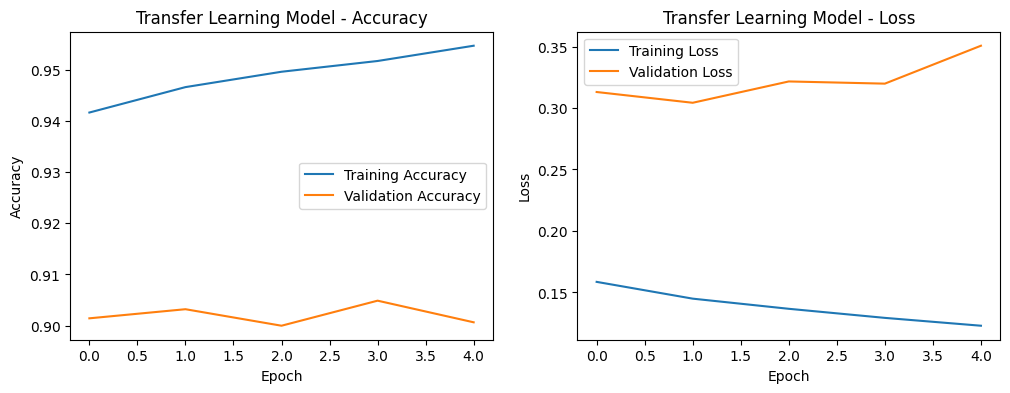

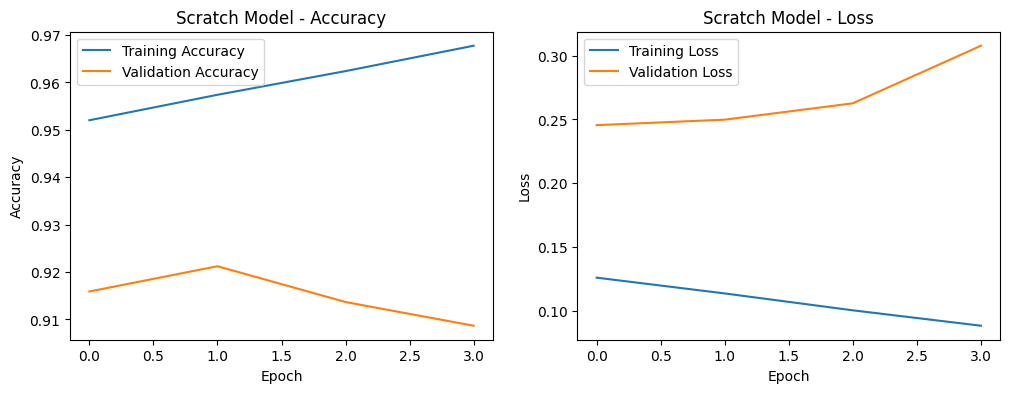

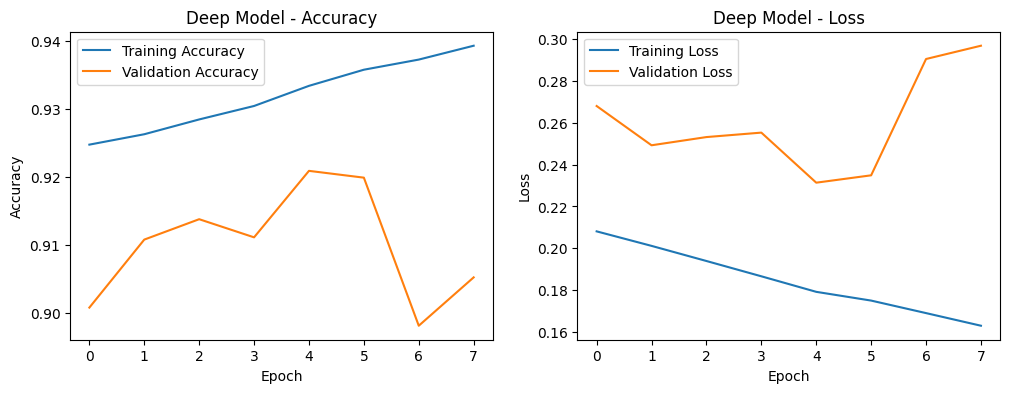

In [14]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history_transfer, 'Transfer Learning Model')
plot_history(history_scratch, 'Scratch Model')
plot_history(history_deep, 'Deep Model')

In [15]:
# Concatenate training and validation data
x_train_full = np.concatenate([x_train, x_val], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)

print("Full training data shape:", x_train_full.shape)  # (54000, 28, 28, 1)
print("Full labels shape:", y_train_full.shape)         # (54000,)

Full training data shape: (60000, 28, 28, 1)
Full labels shape: (60000,)


In [16]:
from sklearn.model_selection import KFold

(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Preprocess data
x_train_full = x_train_full.astype('float32') / 255.0  # Normalize
x_test = x_test.astype('float32') / 255.0
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

# Verify GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:

from sklearn.utils import shuffle
x_train_full, y_train_full = shuffle(x_train_full, y_train_full, random_state=42)

In [19]:
def build_model():
    model = tf.keras.Sequential([

        # Input & Augmentation

        tf.keras.layers.Input(shape=(28,28,1)),
        tf.keras.layers.RandomRotation(0.05),  # Increased rotation
        tf.keras.layers.RandomZoom(0.1),       # Stronger zoom
        tf.keras.layers.RandomContrast(0.2),   # Added contrast jitter

        # Custom augmentation for shirts (class 6)
        tf.keras.layers.Lambda(lambda x: tf.cond(
            tf.equal(tf.argmax(model.output, axis=1)[0], 6),  # If shirt predicted
            lambda: tf.image.flip_left_right(x),              # Flip horizontally
            lambda: x
        )),
        ...
    ])

In [20]:
def build_model():
    # Use Functional API for custom layers
    input_layer = tf.keras.layers.Input(shape=(28,28,1))

    # Augmentation
    x = tf.keras.layers.RandomRotation(0.05)(input_layer)
    x = tf.keras.layers.RandomZoom(0.1)(x)

    # Feature extractor
    x = tf.keras.layers.Conv2D(64, (3,3))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Spatial attention block
    attention = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(x)  # Attention mask
    x = tf.keras.layers.Multiply()([x, attention])  # Apply mask
    x = tf.keras.layers.MaxPooling2D(2,2)(x)
    x = tf.keras.layers.Conv2D(128, (3,3))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.35)(x)
    output = tf.keras.layers.Dense(10, activation='softmax')(x)

    # Build model
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [21]:
from tqdm.keras import TqdmCallback
import warnings


warnings.filterwarnings("ignore", category=UserWarning, message="Even though the.*")
tf.config.run_functions_eagerly(True)

# Initialize KFold
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# Define models
models = {
    "Transfer Model": model_transfer,
    "Scratch Model": model_scratch,
    "Deep Model": model_deep
}

# Cross-validation loop
results = {}
for model_name, original_model in models.items():
    print(f"\n=== Evaluating {model_name} ===")
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train_full)):
        print(f"\n--- Fold {fold + 1} ---")

        # Clone model and reset optimizer
        model = tf.keras.models.clone_model(original_model)
        model.build(original_model.input_shape)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        # Train with progress bar
        history = model.fit(
            x_train_full[train_idx], y_train_full[train_idx],
            epochs=30,
            batch_size=64,
            validation_data=(x_train_full[val_idx], y_train_full[val_idx]),
            class_weight={6: 2.0},
            callbacks=[
                TqdmCallback(),
                tf.keras.callbacks.EarlyStopping(patience=8),
                tf.keras.callbacks.ModelCheckpoint(f"checkpoint_fold_{fold+1}.h5")
            ],
            verbose=0
        )

        # Evaluate
        test_acc = model.evaluate(x_test, y_test, verbose=0)[1]
        fold_accuracies.append(test_acc)
        print(f"Fold {fold + 1} Test Accuracy: {test_acc:.4f}")

    results[model_name] = fold_accuracies


print("\n=== Final Results ===")
for model_name, accs in results.items():
    print(f"{model_name}: Avg Accuracy = {np.mean(accs):.4f}")


=== Evaluating Transfer Model ===

--- Fold 1 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Fold 1 Test Accuracy: 0.8696

--- Fold 2 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Fold 2 Test Accuracy: 0.8763

--- Fold 3 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Fold 3 Test Accuracy: 0.8402

=== Evaluating Scratch Model ===

--- Fold 1 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Fold 1 Test Accuracy: 0.9056

--- Fold 2 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Fold 2 Test Accuracy: 0.9092

--- Fold 3 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Fold 3 Test Accuracy: 0.9036

=== Evaluating Deep Model ===

--- Fold 1 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Fold 1 Test Accuracy: 0.9047

--- Fold 2 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Fold 2 Test Accuracy: 0.8999

--- Fold 3 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Fold 3 Test Accuracy: 0.9024

=== Final Results ===
Transfer Model: Avg Accuracy = 0.8620
Scratch Model: Avg Accuracy = 0.9061
Deep Model: Avg Accuracy = 0.9023


In [22]:

(x_mnist, y_mnist), _ = tf.keras.datasets.mnist.load_data()

# Preprocess MNIST to match Fashion MNIST input shape (28x28x1)
x_mnist = x_mnist.astype('float32') / 255.0
x_mnist = np.expand_dims(x_mnist, axis=-1)

# Evaluate models on MNIST
def evaluate_on_mnist(model, model_name):
    # Predict
    y_pred = model.predict(x_mnist)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate accuracy (MNIST has 10 classes, same as Fashion MNIST)
    accuracy = np.mean(y_pred_labels == y_mnist)

    print(f"{model_name} Accuracy on MNIST: {accuracy:.2%}")
    return accuracy

# Test all models
mnist_accuracies = {
    'Transfer Model': evaluate_on_mnist(model_transfer, 'Transfer Model'),
    'Scratch Model': evaluate_on_mnist(model_scratch, 'Scratch Model'),
    'Deep Model': evaluate_on_mnist(model_deep, 'Deep Model')
}

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step
Transfer Model Accuracy on MNIST: 11.38%
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step
Scratch Model Accuracy on MNIST: 12.18%
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step
Deep Model Accuracy on MNIST: 10.06%


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


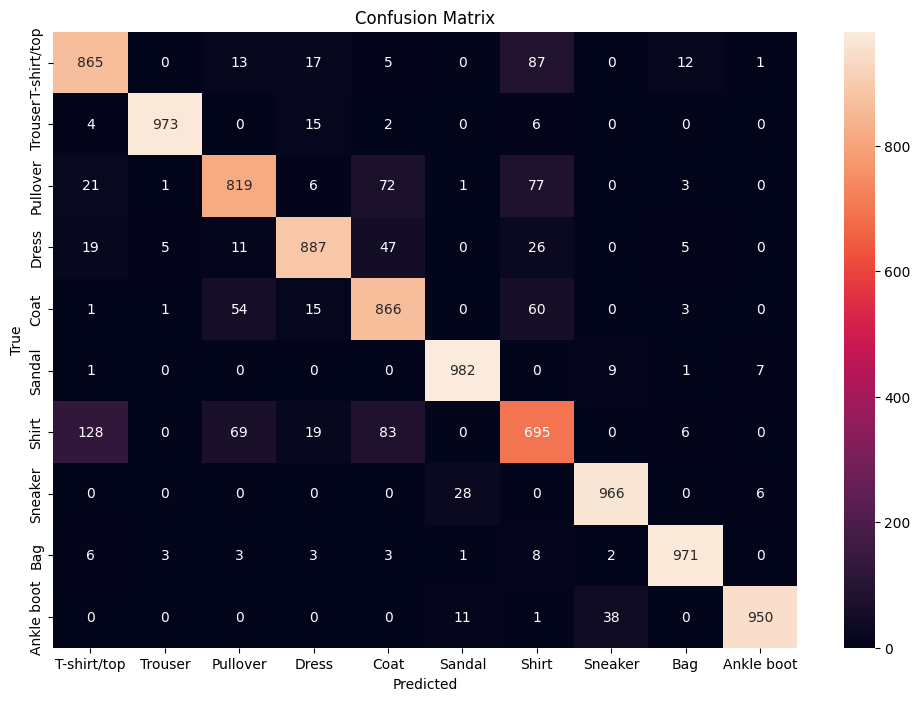

In [23]:
# Import required libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns


model_transfer = tf.keras.models.load_model('fashion_transfer_model.h5')  # Replace with your model path

# Generate predictions
y_pred = model_transfer.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


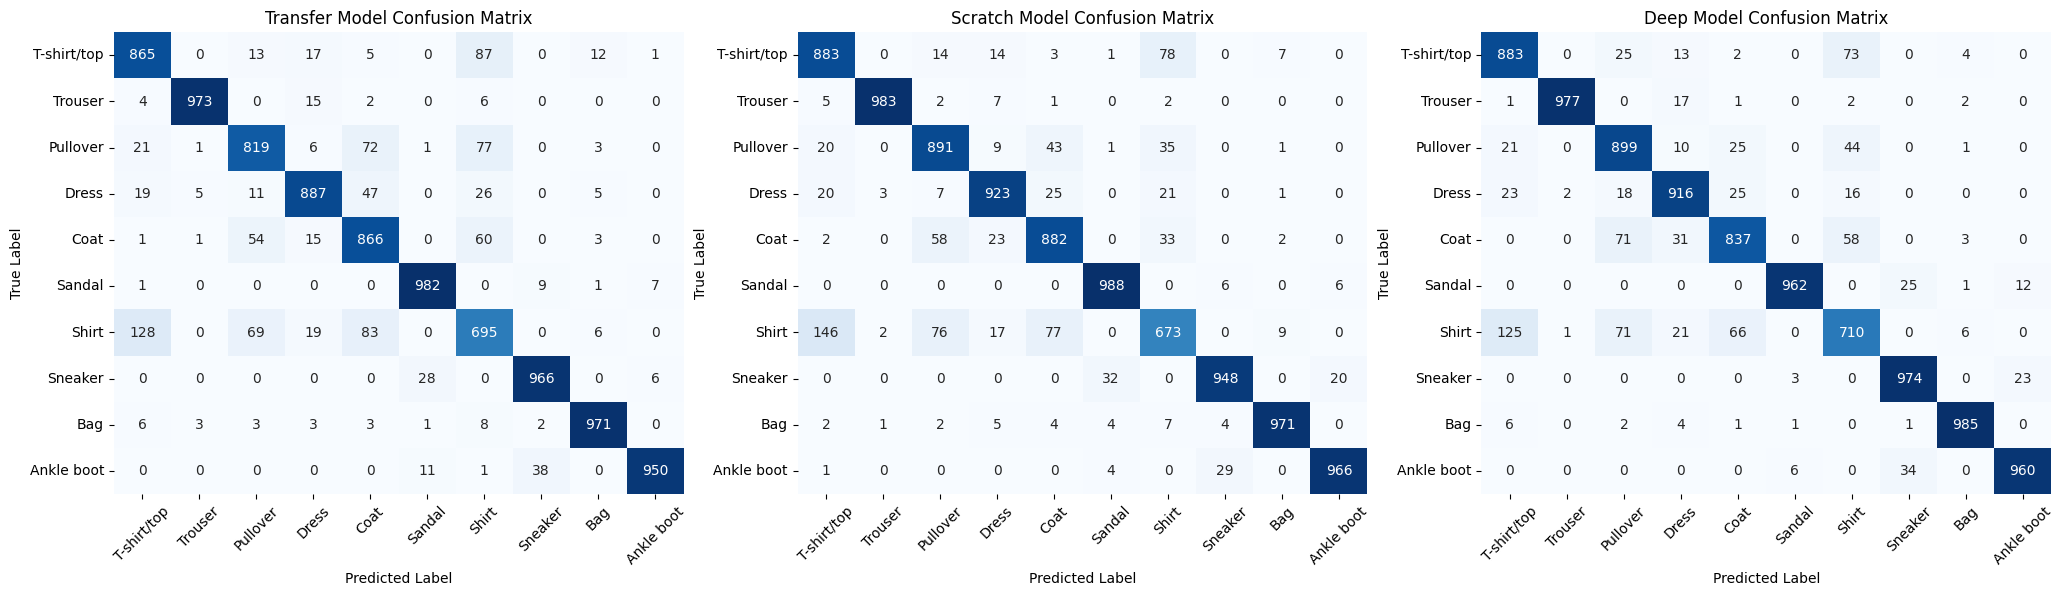

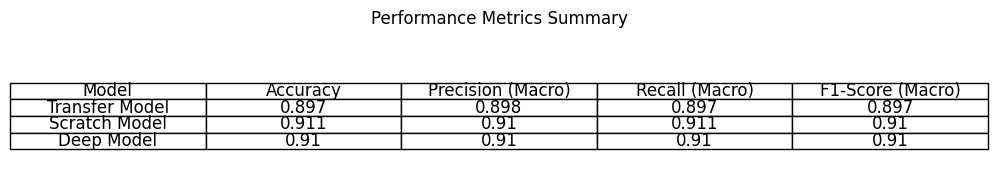

In [24]:
import pandas as pd


models = {
    "Transfer Model": tf.keras.models.load_model('fashion_transfer_model.h5'),
    "Scratch Model": tf.keras.models.load_model('fashion_scratch_model.h5'),
    "Deep Model": tf.keras.models.load_model('fashion_deep_model.h5')
}

# Class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create subplots for confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

metrics_data = []


for idx, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(x_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names,
                yticklabels=class_names,
                ax=axes[idx],
                cmap="Blues",
                cbar=False)
    axes[idx].set_title(f"{model_name} Confusion Matrix")
    axes[idx].set_xlabel("Predicted Label")
    axes[idx].set_ylabel("True Label")
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].tick_params(axis='y', rotation=0)

    report = classification_report(y_test, y_pred_labels, target_names=class_names, output_dict=True)
    metrics_data.append({
        'Model': model_name,
        'Precision (Macro)': report['macro avg']['precision'],
        'Recall (Macro)': report['macro avg']['recall'],
        'F1-Score (Macro)': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    })


metrics_df = pd.DataFrame(metrics_data).round(3)
metrics_df = metrics_df[['Model', 'Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']]


fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
table = ax.table(
    cellText=metrics_df.values,
    colLabels=metrics_df.columns,
    loc='center',
    cellLoc='center'
)
table.set_fontsize(12)
table.scale(1.2, 1.2)
ax.set_title('Performance Metrics Summary', pad=20)

plt.tight_layout()
plt.show()

In [25]:
# Predict on test set
y_pred = model_transfer.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Find misclassified indices
misclassified_indices = np.where(y_pred_labels != y_test)[0][:15]  # First 10 errors

# Save these images
import os
os.makedirs('iiif_annotations/images', exist_ok=True)
for idx in misclassified_indices:
    plt.imsave(f'iiif_annotations/images/test_{idx}.png', x_test[idx].squeeze(), cmap='gray')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [26]:
# Get prediction probabilities
y_pred_probs = model_transfer.predict(x_test)
max_probs = np.max(y_pred_probs, axis=1)

# Find low-confidence images
low_confidence_indices = np.where(max_probs < 0.8)[0][:5]

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [27]:


# 1. Load Model and Data

model = tf.keras.models.load_model('fashion_transfer_model.h5')
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize test set
x_test = x_test.astype('float32') / 255.0
x_test = np.expand_dims(x_test, axis=-1)

# Ensure y_test is correctly shaped (1D array)
y_test = np.squeeze(y_test)

# Class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# 2. Get Model Predictions

y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
confidences = np.max(y_pred, axis=1)


# 3. Identify Misclassified Images

misclassified_indices = np.where(y_pred_labels != y_test)[0]


num_misclassified = min(15, len(misclassified_indices))
misclassified_indices = misclassified_indices[:num_misclassified]

print(f"Total misclassified images found: {len(misclassified_indices)}")


# 4.Find Low-Confidence Predictions

low_confidence_threshold = 0.8
low_confidence_indices = np.where(confidences < low_confidence_threshold)[0]

print(f"Total low-confidence predictions: {len(low_confidence_indices)}")

# 5. Populate Annotations Data

annotations_data = {}
for idx in misclassified_indices:
    annotations_data[idx] = {
        "true_label": class_names[y_test[idx]],
        "predicted_label": class_names[y_pred_labels[idx]],
        "confidence": round(confidences[idx], 4)
    }

print("Annotations Data:", annotations_data)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Total misclassified images found: 15
Total low-confidence predictions: 1421
Annotations Data: {np.int64(12): {'true_label': 'Sneaker', 'predicted_label': 'Sandal', 'confidence': np.float32(0.9975)}, np.int64(17): {'true_label': 'Coat', 'predicted_label': 'Shirt', 'confidence': np.float32(0.5667)}, np.int64(23): {'true_label': 'Ankle boot', 'predicted_label': 'Sandal', 'confidence': np.float32(1.0)}, np.int64(25): {'true_label': 'Coat', 'predicted_label': 'Pullover', 'confidence': np.float32(0.9987)}, np.int64(29): {'true_label': 'Dress', 'predicted_label': 'Coat', 'confidence': np.float32(0.8053)}, np.int64(42): {'true_label': 'Dress', 'predicted_label': 'Shirt', 'confidence': np.float32(0.8293)}, np.int64(44): {'true_label': 'Shirt', 'predicted_label': 'Coat', 'confidence': np.float32(0.8724)}, np.int64(48): {'true_label': 'Pullover', 'predicted_label': 'Coat', 'confidence': np.float32(0.6131)}, np.int64(49): {'true_label': 'Pullover', 'predict

In [28]:
from PIL import Image

input_folder = "iiif_annotations/images"
output_folder = "iiif_annotations/images_resized"
os.makedirs(output_folder, exist_ok=True)

# Upscale images to 224x224
for filename in os.listdir(input_folder):
    if filename.endswith(".png"):
        img = Image.open(os.path.join(input_folder, filename))

        img_resized = img.resize((224, 224), Image.NEAREST)

        img_resized.save(os.path.join(output_folder, filename))

print("Resizing complete!")

Resizing complete!


In [48]:
import requests
from io import BytesIO
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from bs4 import BeautifulSoup

# Configuration
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

MODELS = {
    "Transfer Model": tf.keras.models.load_model('fashion_transfer_model.h5'),
    "Scratch Model": tf.keras.models.load_model('fashion_scratch_model.h5'),
    "Deep Model": tf.keras.models.load_model('fashion_deep_model.h5')
}

# Annotation-image mapping
ANNOTATION_IMAGE_MAP = {
    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/be5af319de95bf25098d6d5b30711ebb.json":
    "https://ashkanaln.github.io/Ashkan9/images/shirt/full/full/0/default.jpg",

    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/84da49f927a4a8a385118ec1a7fac9bc.json":
    "https://ashkanaln.github.io/Ashkan9/images/trouser/full/full/0/default.jpg",

    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/4d80351b1263e5331157f7f4732362dc.json":
    "https://ashkanaln.github.io/Ashkan9/images/bag/full/full/0/default.jpg",

    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/0b1ea9b77bea7e79bdb562ac2959cfab.json":
    "https://ashkanaln.github.io/Ashkan9/images/sandal/full/full/0/default.jpg",

    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/ecc7bdec4756c5e8579b508a7bded7de.json":
    "https://ashkanaln.github.io/Ashkan9/images/shirt1/full/full/0/default.jpg",

    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/8780217fd615f6254d3fc124499511b7.json":
    "https://ashkanaln.github.io/Ashkan9/images/dress/full/full/0/default.jpg",

    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/e30e1c98b6879da3475fb9d3170ffea5.json":
    "https://ashkanaln.github.io/Ashkan9/images/bag1/full/full/0/default.jpg",

    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/2f4e16a67c1586cb780a6f7f4ed959a8.json":
    "https://ashkanaln.github.io/Ashkan9/images/pullover/full/full/0/default.jpg",

    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/c37e0dd5c837e9b19ce4c0e859268301.json":
    "https://ashkanaln.github.io/Ashkan9/images/sneaker/full/full/0/default.jpg",

    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/7336e40761f78e380da0cb32cbd3d01c.json":
    "https://ashkanaln.github.io/Ashkan9/images/boot/full/full/0/default.jpg",

    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/0de12f0e3ed893be6a864d96f5fb9c98.json":
    "https://ashkanaln.github.io/Ashkan9/images/t-shirt/full/full/0/default.jpg",

    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/ad38d16991109240106c28b66222d8c5.json":
    "https://ashkanaln.github.io/Ashkan9/images/dress1/full/full/0/default.jpg",

    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/d5802267798e9c2a067beb1f9080af79.json":
    "https://ashkanaln.github.io/Ashkan9/images/trouser1/full/full/0/default.jpg",

    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/dc7702060d458a0d8766fd16fa7b7683.json":
    "https://ashkanaln.github.io/Ashkan9/images/coat/full/full/0/default.jpg",

    "https://dev.gdmrdigital.com/annotations/1245635613/200658288/835675fba342ebe2090bc6b72a91d3b7.json":
    "https://ashkanaln.github.io/Ashkan9/images/T-shirt1/full/full/0/default.jpg",
}

def preprocess_image(image_url, debug=False):
    """Preprocess and optionally visualize"""
    try:

        response = requests.get(image_url)
        original_img = Image.open(BytesIO(response.content))

        # Preprocessing pipeline
        img = original_img.copy()
        img = img.convert('L').point(lambda x: 255 - x)
        img = img.resize((28, 28), Image.LANCZOS)
        img_array = np.array(img) / 255.0

        if debug:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(original_img)
            ax[0].set_title(f"Original\n{image_url}")
            ax[0].axis('off')

            ax[1].imshow(img_array, cmap='gray', vmin=0, vmax=1)
            ax[1].set_title("Model Input (28x28 Grayscale)")
            ax[1].axis('off')
            plt.show()

        return np.expand_dims(img_array, axis=(0, -1))
    except Exception as e:
        print(f"Error processing {image_url}: {str(e)}")
        return None

def parse_annotation(url):
    """Parse annotation to get true label"""
    try:
        response = requests.get(url, timeout=10)
        data = response.json()
        text_resource = data['resources'][0]['resource'][0]
        html_content = text_resource.get('chars', '')
        clean_text = BeautifulSoup(html_content, "html.parser").get_text().strip()
        return clean_text.split("True: ")[1].strip()
    except Exception as e:
        print(f"Error parsing {url}: {str(e)}")
        return None

def evaluate_models():
    """Main evaluation workflow"""
    results = []
    for ann_url, img_url in ANNOTATION_IMAGE_MAP.items():
        true_label = parse_annotation(ann_url)
        if not true_label:
            continue

        img_array = preprocess_image(img_url)
        if img_array is None:
            continue

        sample = {
            'annotation_url': ann_url,
            'image_url': img_url,
            'true_label': true_label,
            'true_class': CLASS_NAMES.index(true_label)
        }

        for model_name, model in MODELS.items():
            try:
                pred = model.predict(img_array, verbose=0)
                pred_class = np.argmax(pred)
                sample[f'{model_name}_pred'] = CLASS_NAMES[pred_class]
                sample[f'{model_name}_conf'] = float(np.max(pred))
            except Exception as e:
                print(f"{model_name} error: {str(e)}")
                sample[f'{model_name}_pred'] = None
                sample[f'{model_name}_conf'] = None

        results.append(sample)
    return pd.DataFrame(results)

def generate_report(df):
    """Generate accuracy metrics and confusion matrices"""
    report = {}
    for model_name in MODELS.keys():
        valid_samples = df.dropna(subset=[f'{model_name}_pred'])
        if valid_samples.empty:
            print(f"Skipping {model_name} - No valid predictions.")
            continue

        y_true = valid_samples['true_class'].tolist()
        y_pred = [CLASS_NAMES.index(p) for p in valid_samples[f'{model_name}_pred']]

        accuracy = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=range(10))

        report[model_name] = {
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'class_report': classification_report(
                y_true, y_pred, labels=range(10),
                target_names=CLASS_NAMES,
                zero_division=0
            )
        }
    return report

# Main execution flow
if __name__ == "__main__":
    df = evaluate_models()
    report = generate_report(df)

    print("\nPredictions:")
    print(df[['image_url', 'true_label', 'Transfer Model_pred', 'Scratch Model_pred', 'Deep Model_pred']])

    df.to_csv('iiif_model_comparison.csv', index=False)

    print("\nModel Performance Summary:")
    for model_name, metrics in report.items():
        print(f"\n=== {model_name} ===")
        print(f"Accuracy: {metrics['accuracy']:.2%}")
        print("Confusion Matrix:")
        print(metrics['confusion_matrix'])
        print("\nClass-wise Report:")
        print(metrics['class_report'])

    print("\nFull results saved to iiif_model_comparison.csv")


Predictions:
                                            image_url   true_label  \
0   https://ashkanaln.github.io/Ashkan9/images/shi...        Shirt   
1   https://ashkanaln.github.io/Ashkan9/images/tro...      Trouser   
2   https://ashkanaln.github.io/Ashkan9/images/bag...          Bag   
3   https://ashkanaln.github.io/Ashkan9/images/san...       Sandal   
4   https://ashkanaln.github.io/Ashkan9/images/shi...        Shirt   
5   https://ashkanaln.github.io/Ashkan9/images/dre...        Dress   
6   https://ashkanaln.github.io/Ashkan9/images/bag...          Bag   
7   https://ashkanaln.github.io/Ashkan9/images/pul...     Pullover   
8   https://ashkanaln.github.io/Ashkan9/images/sne...      Sneaker   
9   https://ashkanaln.github.io/Ashkan9/images/boo...   Ankle boot   
10  https://ashkanaln.github.io/Ashkan9/images/t-s...  T-shirt/top   
11  https://ashkanaln.github.io/Ashkan9/images/dre...        Dress   
12  https://ashkanaln.github.io/Ashkan9/images/tro...      Trouser   
13  ht


Confusion Matrices in Table Format:


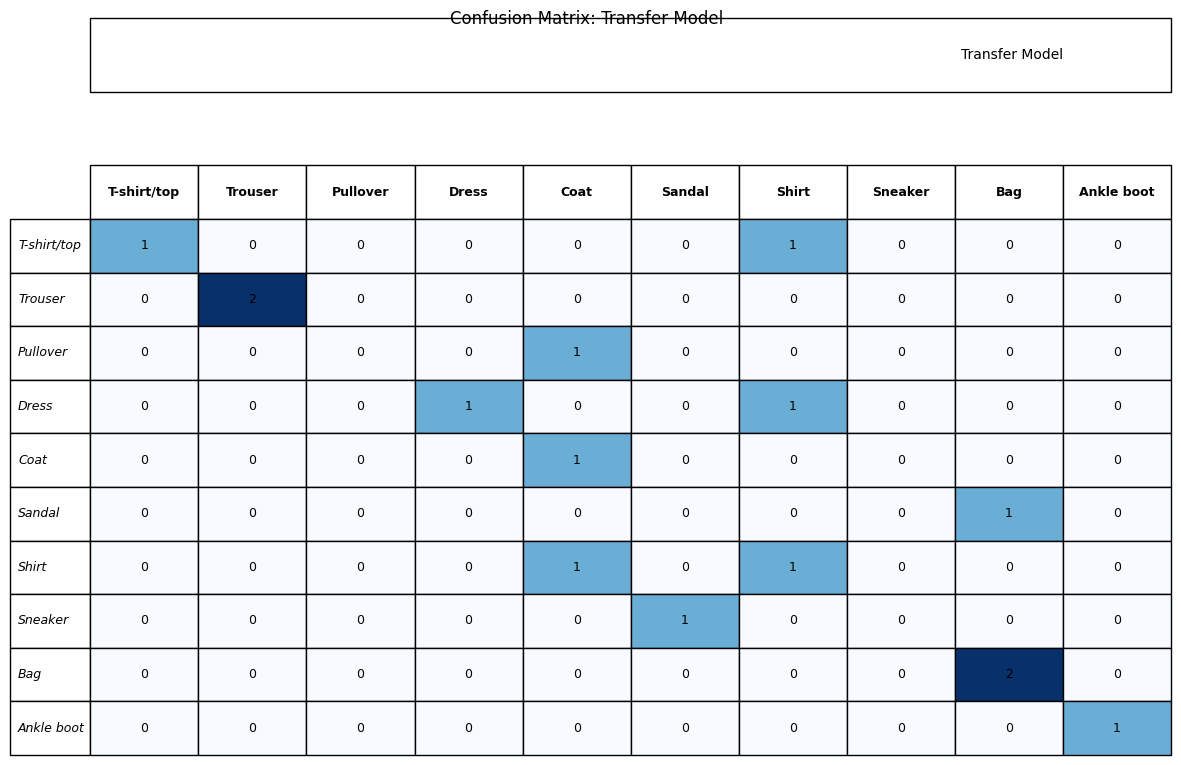

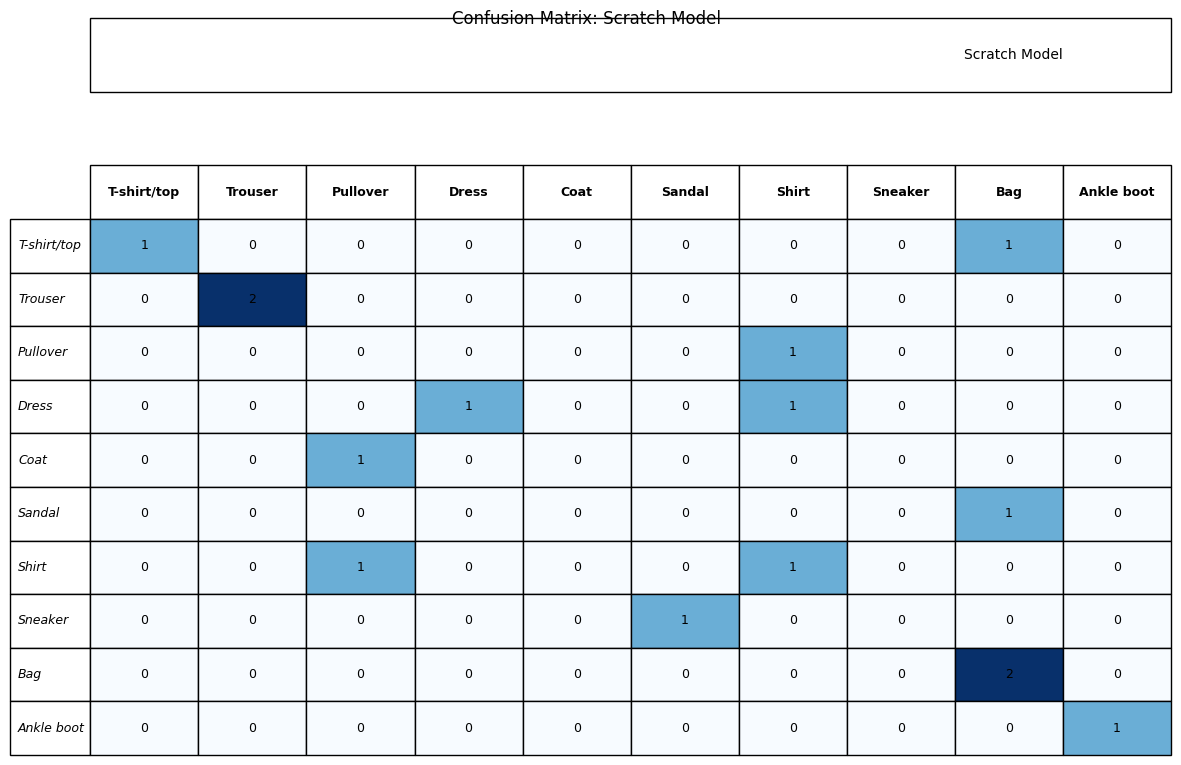

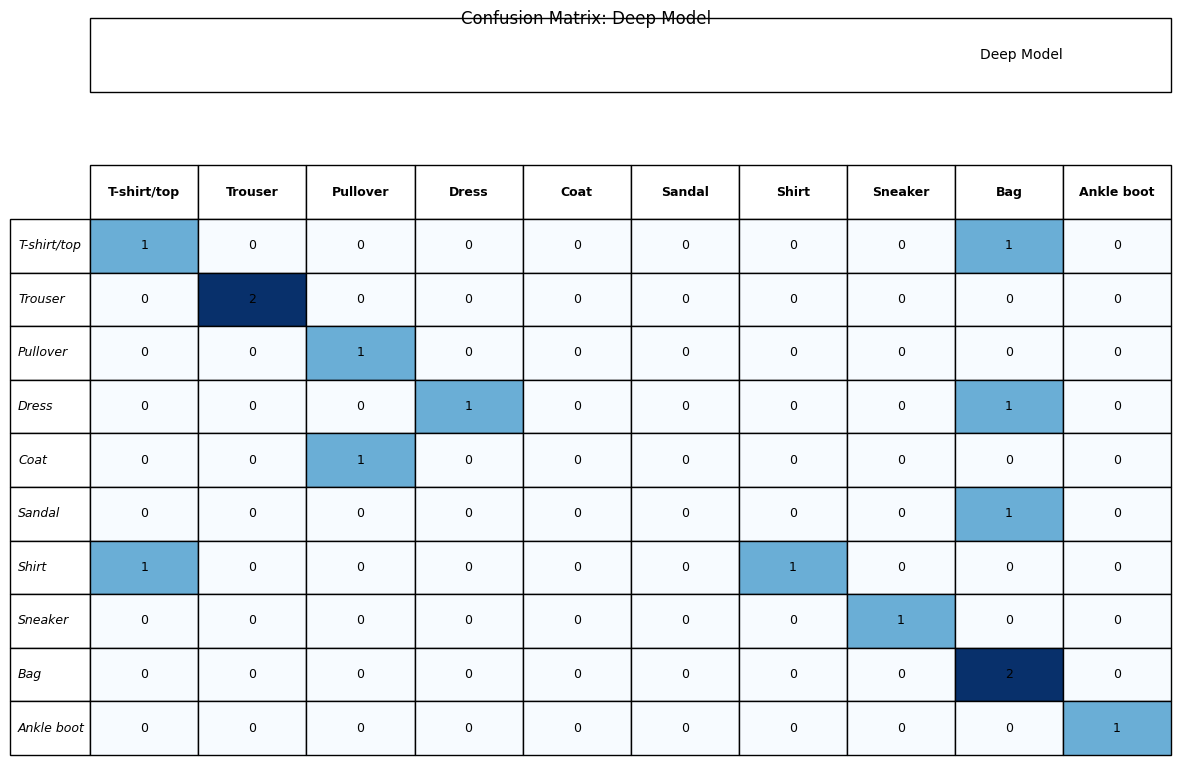

In [41]:
def plot_confusion_matrix_table(report, model_name):

    cm = report[model_name]['confusion_matrix']
    metrics_df = pd.DataFrame(cm, columns=CLASS_NAMES, index=CLASS_NAMES)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')

    header = [plt.table(cellText=[[model_name]],
                       colWidths=[1],
                       loc='top',
                       bbox=[0, 0.9, 1, 0.1])]

    table = ax.table(
        cellText=metrics_df.values.round(2),
        rowLabels=metrics_df.index,
        colLabels=metrics_df.columns,
        loc='center',
        bbox=[0, 0, 1, 0.8],
        cellLoc='center'
    )

    table.set_fontsize(10)
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold')
        if col == -1:
            cell.set_text_props(style='italic')

    norm = plt.Normalize(vmin=0, vmax=cm.max())
    colors = plt.cm.Blues(norm(cm.flatten())).reshape(cm.shape + (4,))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            table[(i+1, j)].set_facecolor(colors[i, j])

    plt.suptitle(f'Confusion Matrix: {model_name}', y=0.95)
    plt.tight_layout()
    plt.show()

print("\nConfusion Matrices in Table Format:")
for model_name in report.keys():
    plot_confusion_matrix_table(report, model_name)

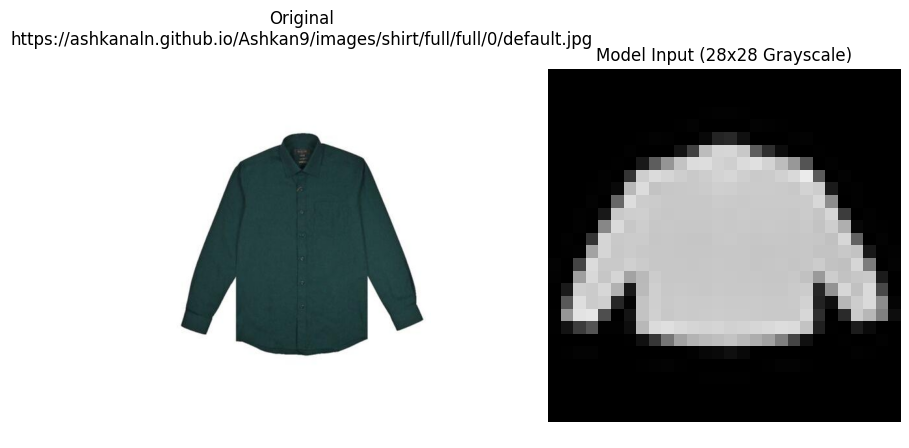

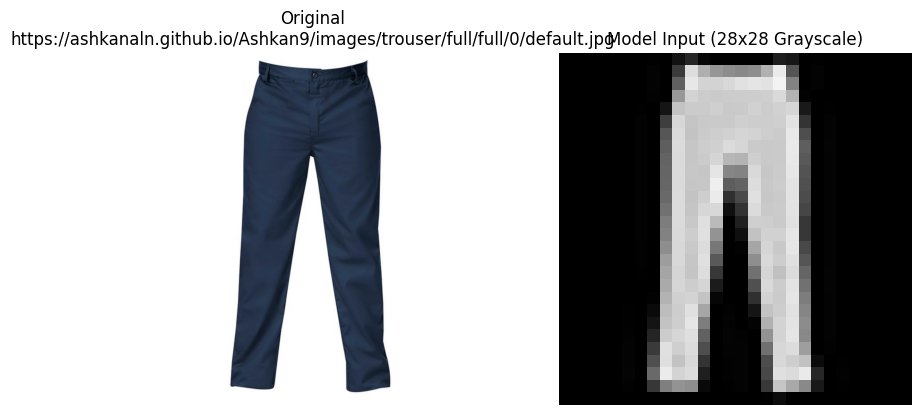

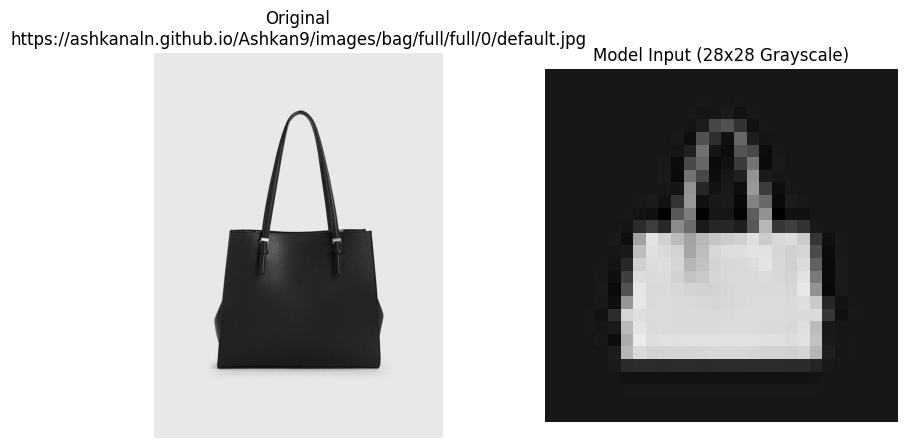

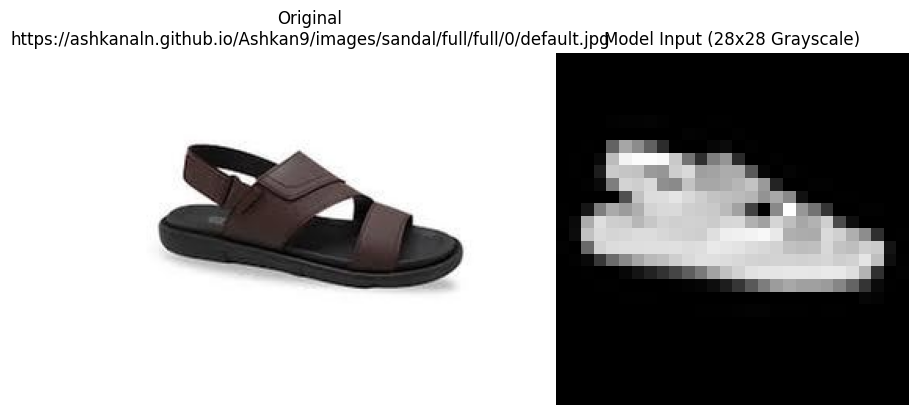

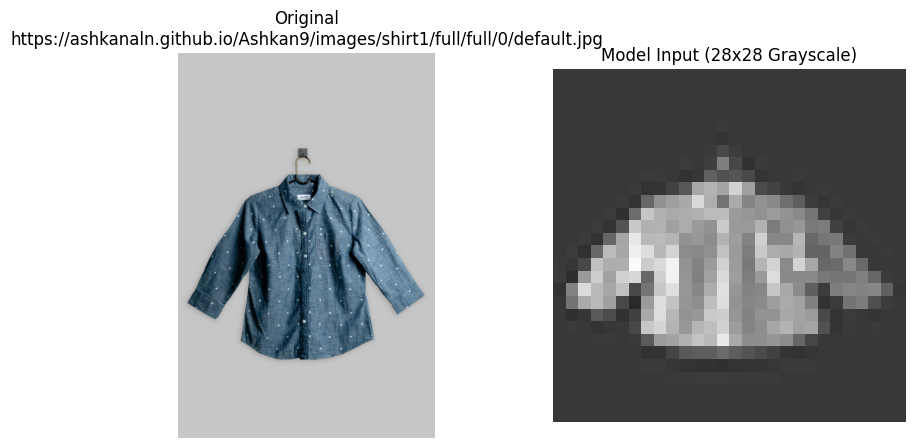

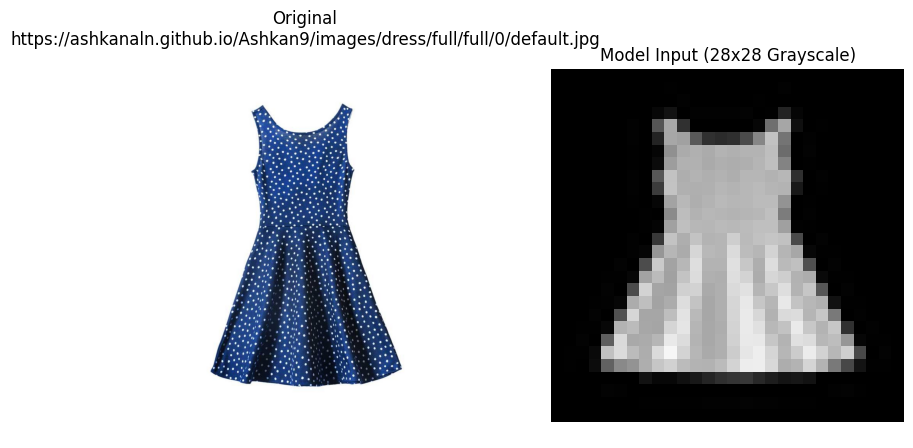

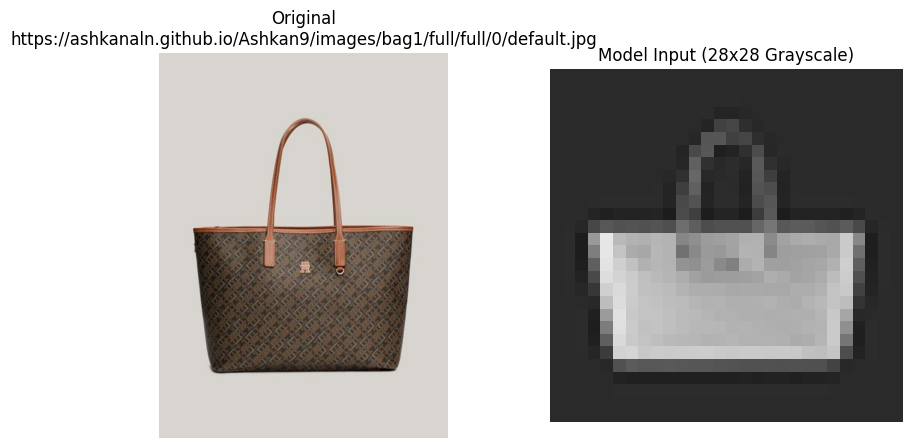

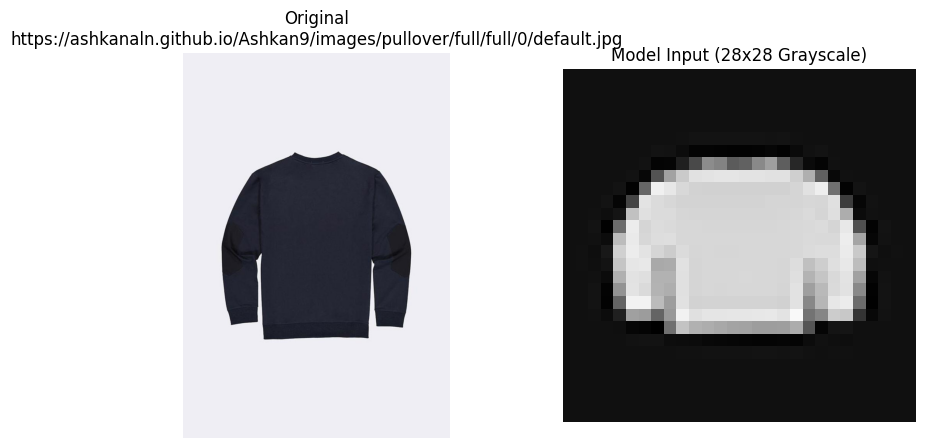

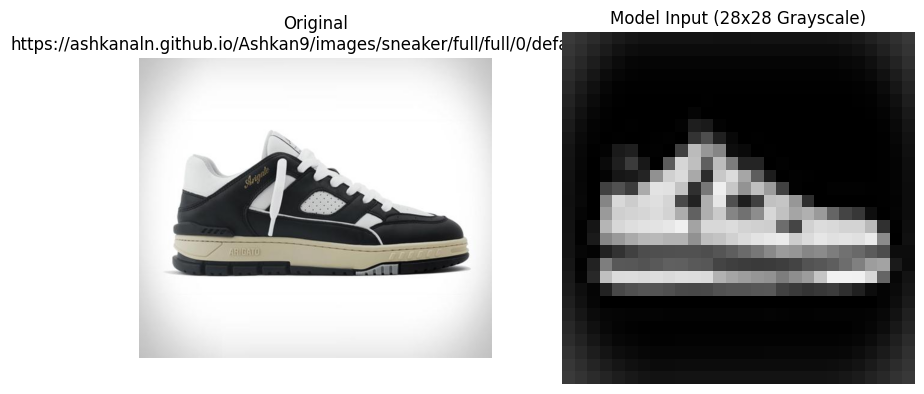

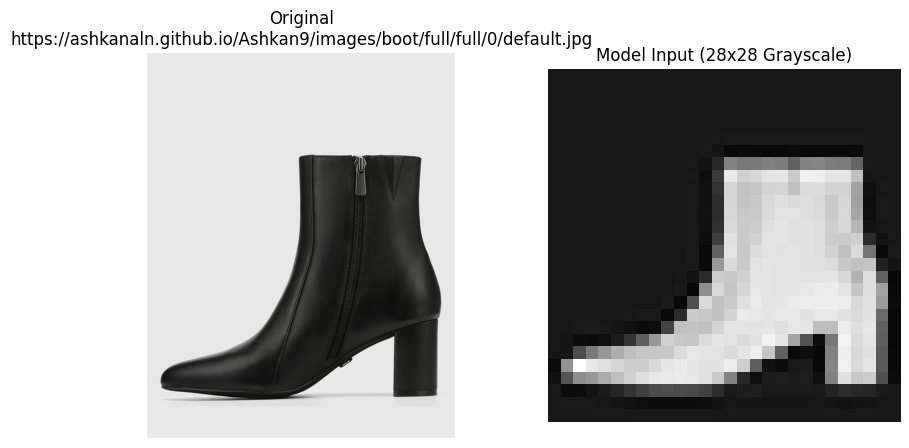

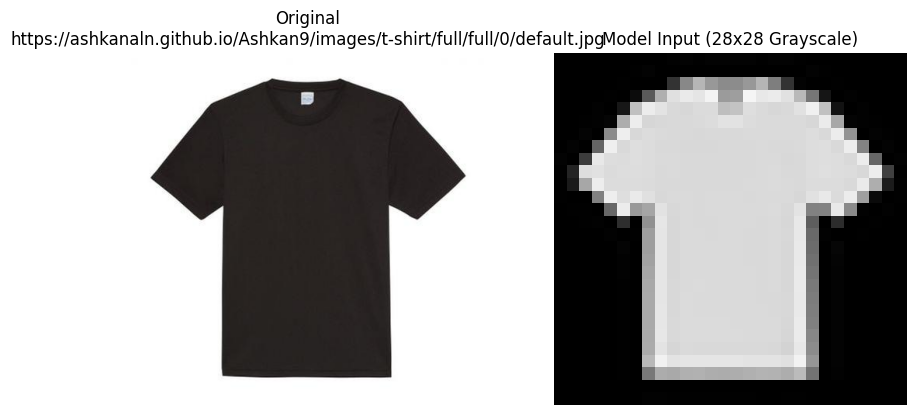

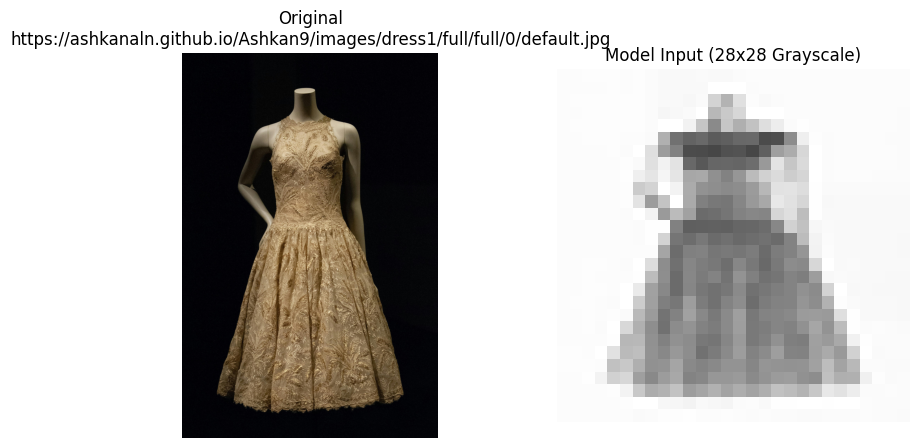

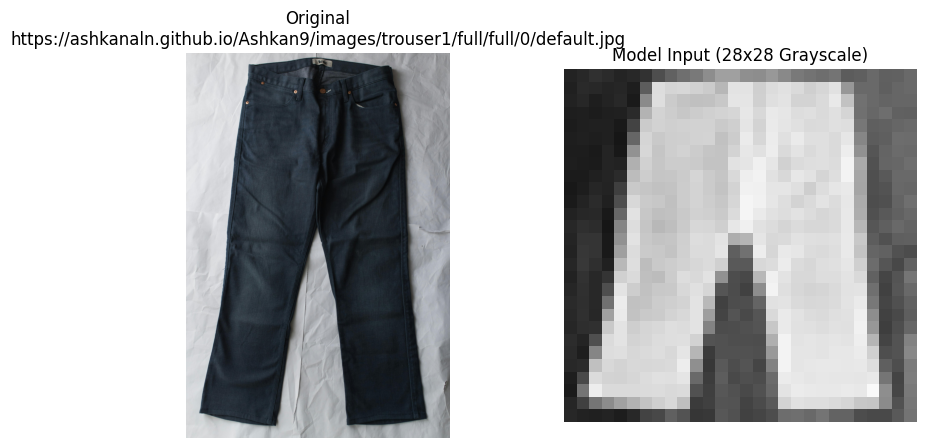

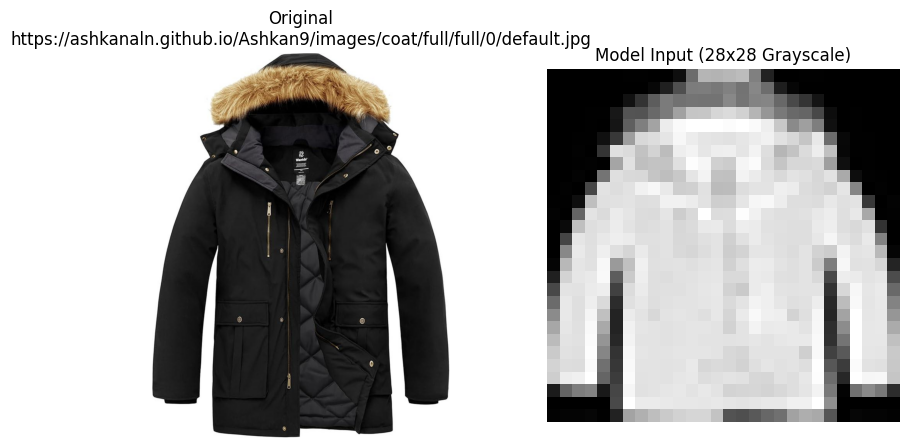

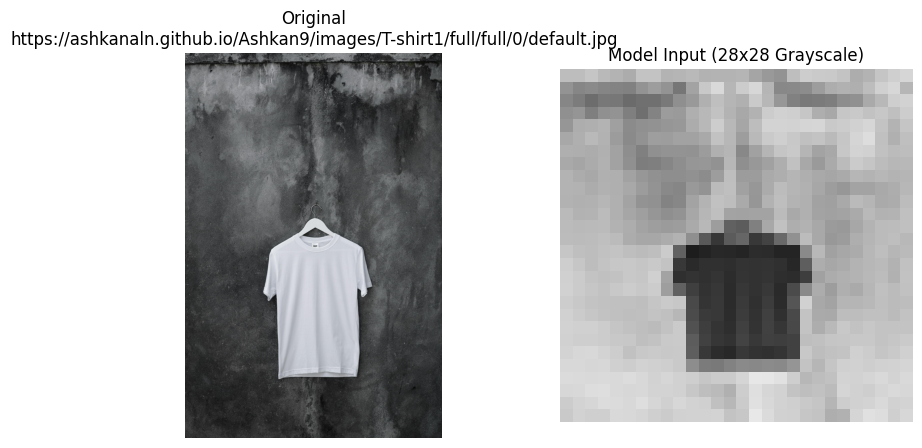

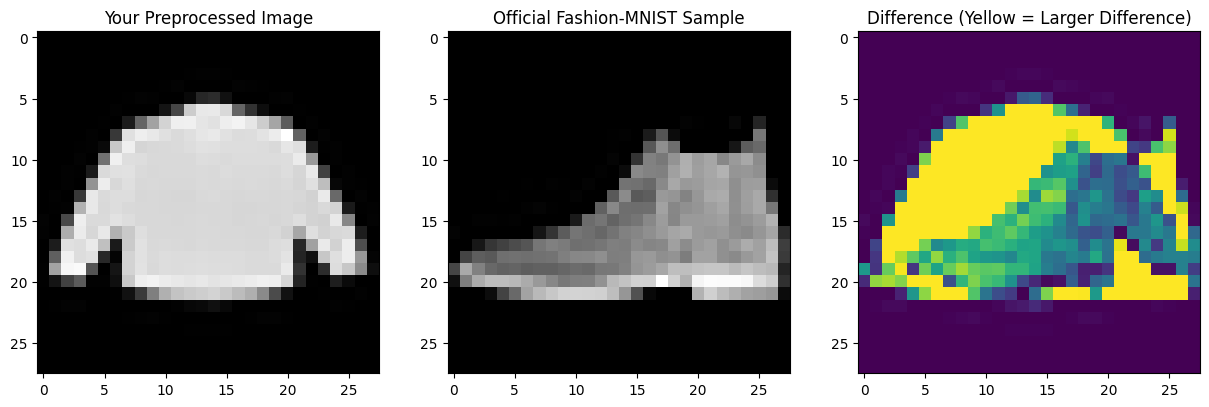

In [49]:
# Visualize preprocessing for all 15 images
for img_url in ANNOTATION_IMAGE_MAP.values():
    _ = preprocess_image(img_url, debug=True)
    plt.close()

(_, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
sample_idx = 0

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

your_img = preprocess_image(list(ANNOTATION_IMAGE_MAP.values())[0])[0,:,:,0]
ax[0].imshow(your_img, cmap='gray')
ax[0].set_title("Your Preprocessed Image")

ax[1].imshow(x_test[sample_idx], cmap='gray')
ax[1].set_title("Official Fashion-MNIST Sample")

diff = np.abs(your_img - x_test[sample_idx]/255.0)
ax[2].imshow(diff, cmap='viridis', vmin=0, vmax=0.5)
ax[2].set_title("Difference (Yellow = Larger Difference)")
plt.show()